In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dataa', 'datad', 'datac', 'datab', 'datae']


In [2]:
image_path = '../input/dataa/dataA/CameraRGB/'
mask_path = '../input/dataa/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [3]:
#name2id = {n:i for i, n in enumerate(classes)}
#id2name = {i:n for i, n in enumerate(classes)}

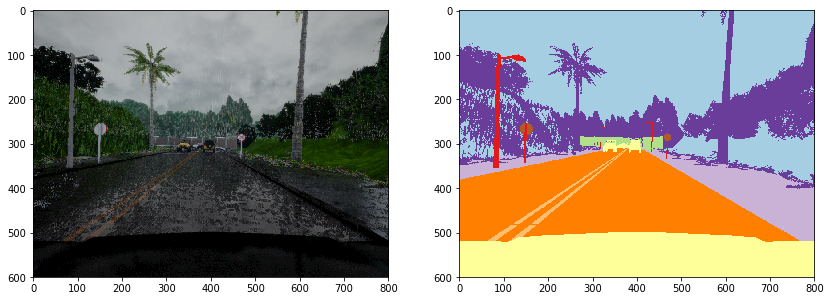

In [4]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[1].imshow(mask, cmap='Paired')

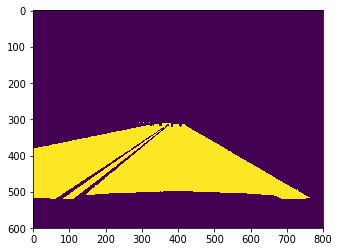

In [5]:
kk = np.zeros((600, 800))
kk[np.where(mask==7)[0], np.where(mask==7)[1]]=1
plt.imshow(kk)

In [6]:
from tqdm import tqdm

In [7]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


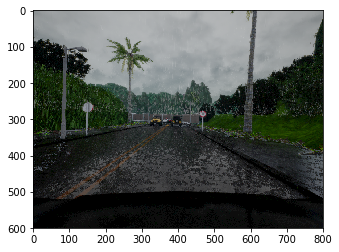

In [8]:
plt.imshow(images[1].reshape(600, 800, 3))

In [9]:
np.random.seed(123)
shuffle_ids = np.random.randint(0, len(masks), len(masks))
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [10]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [11]:
train_images.shape, val_images.shape, test_images.shape

((800, 600, 800, 3), (100, 600, 800, 3), (100, 600, 800, 3))

# Let's build U-Net

In [12]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [13]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 600, 800, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [14]:
callbacks = [
    EarlyStopping(patience=6, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(train_images, train_masks, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(val_images, val_masks))

Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 80s 100ms/step - loss: 0.7698 - val_loss: 0.4087

Epoch 00001: val_loss improved from inf to 0.40869, saving model to model-sdc-seg-1.h5
Epoch 2/100
800/800 [==============================] - 70s 88ms/step - loss: 0.3783 - val_loss: 0.3566

Epoch 00002: val_loss improved from 0.40869 to 0.35662, saving model to model-sdc-seg-1.h5
Epoch 3/100
800/800 [==============================] - 70s 88ms/step - loss: 0.3287 - val_loss: 0.3527

Epoch 00003: val_loss improved from 0.35662 to 0.35270, saving model to model-sdc-seg-1.h5
Epoch 4/100
800/800 [==============================] - 70s 88ms/step - loss: 0.3440 - val_loss: 0.3254

Epoch 00004: val_loss improved from 0.35270 to 0.32539, saving model to model-sdc-seg-1.h5
Epoch 5/100
800/800 [==============================] - 70s 88ms/step - loss: 0.2844 - val_loss: 0.2990

Epoch 00005: val_loss improved from 0.32539 to 0.29896, saving model to m

800/800 [==============================] - 71s 88ms/step - loss: 0.0274 - val_loss: 0.0334

Epoch 00044: val_loss improved from 0.03354 to 0.03344, saving model to model-sdc-seg-1.h5
Epoch 45/100
800/800 [==============================] - 70s 88ms/step - loss: 0.0268 - val_loss: 0.0326

Epoch 00045: val_loss improved from 0.03344 to 0.03256, saving model to model-sdc-seg-1.h5
Epoch 46/100
800/800 [==============================] - 70s 88ms/step - loss: 0.0263 - val_loss: 0.0337

Epoch 00046: val_loss did not improve from 0.03256
Epoch 47/100
800/800 [==============================] - 70s 88ms/step - loss: 0.0267 - val_loss: 0.0321

Epoch 00047: val_loss improved from 0.03256 to 0.03213, saving model to model-sdc-seg-1.h5
Epoch 48/100
800/800 [==============================] - 70s 88ms/step - loss: 0.0257 - val_loss: 0.0317

Epoch 00048: val_loss improved from 0.03213 to 0.03172, saving model to model-sdc-seg-1.h5
Epoch 49/100
800/800 [==============================] - 70s 88ms/step - l

In [15]:
model.save('final-road-seg-model-v2.h5')

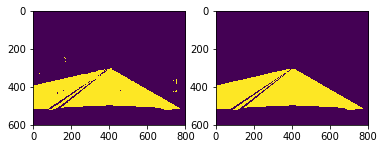

In [16]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))

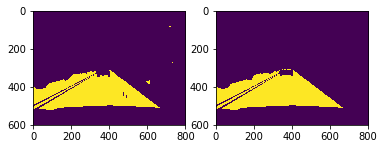

In [29]:
NUMBER += 1
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))